## 06 - Working with Rasters

In this notebook, we will:

- Download rasters from EarthByte's webDAV server
- Plot rasters
- Resize and respace rasters
- Linearly interpolate point data on rasters.

Import all needed packages, and create `PlateReconstruction` and `Plot` objects for the Muller et al. 2019 Tectonics Plate Model.

In [1]:
import glob, os
import pygplates
import gplately
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

In [2]:
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
coastlines, continents, COBs = gdownload.get_topology_geometries()

time = 0 # Ma
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

## GPlately's `DataServer` for rasters

Let's use GPlately's `DataServer` object to download Muller et al. 2019 netCDF age grids. There is a unique age grid for each millionth year - let's access the 0 Ma age grid by passing `time` to `get_age_grid`. It is returned as a masked array.

In [3]:
time = 0 # Ma
muller_2019_age_grid = gdownload.get_age_grid(time)

## Plotting rasters
The `Raster` object allows us to work with age grids and other rasters. Let's specify that `muller_2019_age_grid` is an `array` and visualise the data with `imshow`.

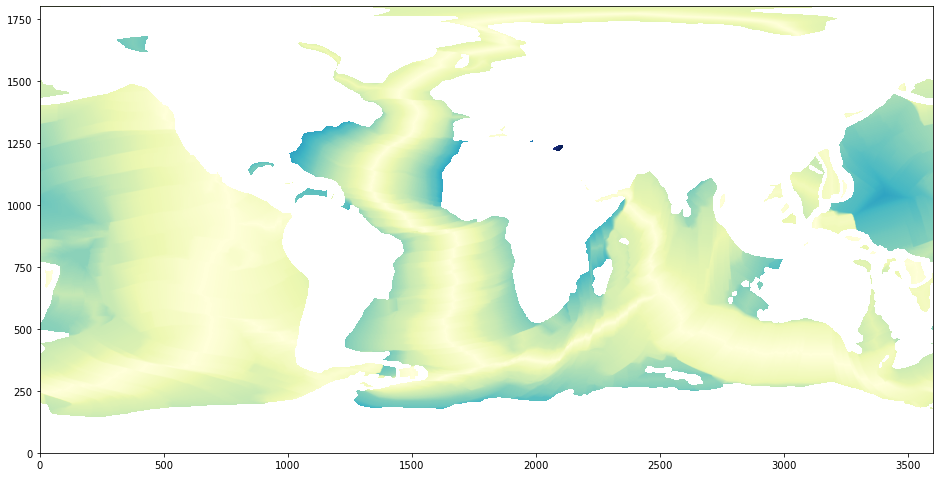

In [4]:
# Call the raster object with the 
graster = gplately.Raster(model, array=muller_2019_age_grid, extent=[-180,180,-90,90])
fig = plt.figure(figsize=(16,12))
plt.imshow(graster.data, origin="lower", cmap="YlGnBu")

Let's plot this netCDF grid along with coastlines, mid-ocean ridges and subduction zones (with teeth) resolved from the Muller et al. 2019 plate model.

Text(0.5, 1.0, '0 Ma')

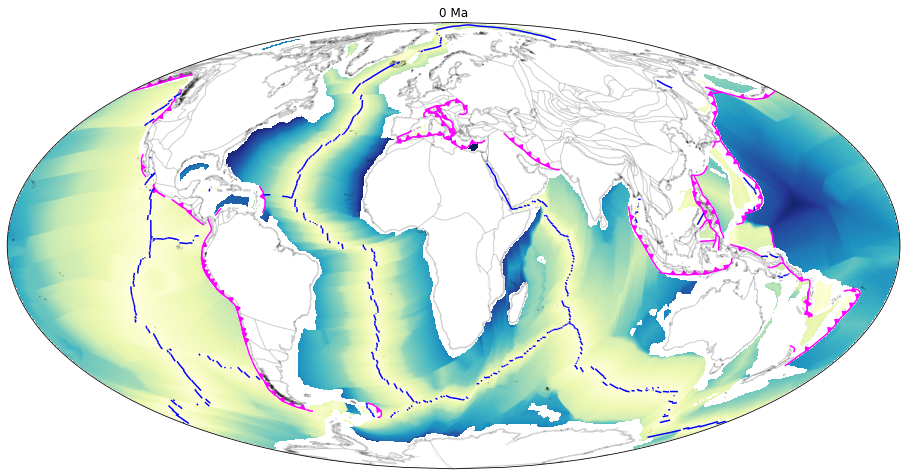

In [5]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 20))
gplot.time = time
gplot.plot_grid(ax1, graster.data, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='1', alpha=0.1)
gplot.plot_trenches(ax1, color='magenta', zorder=5)
gplot.plot_ridges(ax1, color='b', zorder=5)
gplot.plot_subduction_teeth(ax1, color='magenta')
plt.title("%i Ma" %time)

## Resizing and resampling rasters
Let's resize and resample the the present-day Muller et al. 2019 agegrid.

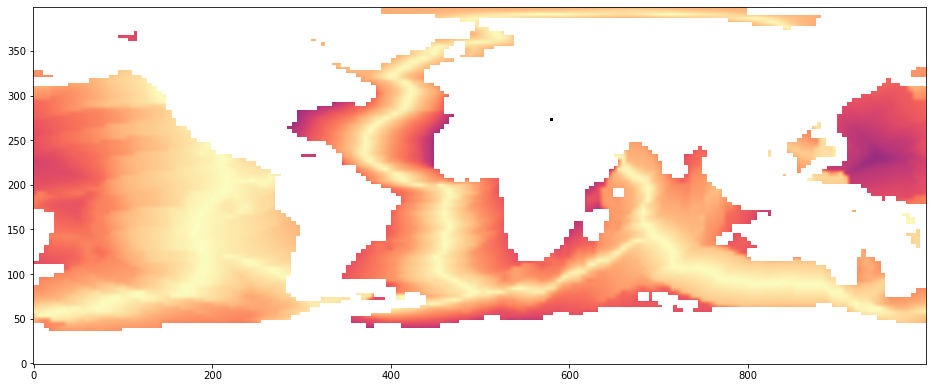

In [6]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
muller_2019_age_grid = gdownload.get_age_grid(time)
graster = gplately.Raster(model, array=muller_2019_age_grid, extent=[-180,180,-90,90])

# Set grid pixel resolution
graster.resample(2,2, overwrite=True)

# Set grid size in x and y directions
graster.resize(1000, 400, overwrite=True)

# Plot resampled and resized age grid
fig = plt.figure(figsize=(16,12))
plt.imshow(graster.data, origin="lower", cmap="magma_r")

## Linear interpolation 
As an example of linear interpolation, let's project points along trenches out a distance of 250km and check which projected points lie inside a continental raster.

In [7]:
# Define the continental grid
continental_grid_directory = "./NotebookFiles/continental_grid_0.nc"
continental_raster = gplately.Raster(model, continental_grid_directory, extent=[-180,180,-90,90])

# Extract subduction polarity angle, and the lat-lon coordinates of each trench point 
trench_data = model.tesselate_subduction_zones(time, ignore_warnings=True)
trench_normal_azimuthal_angle = trench_data[:,7]
trench_pt_lon = trench_data[:,0]
trench_pt_lat = trench_data[:,1]
    
# Project the 250km arc-trench distance onto an Earth sphere
arc_distance = 250 / (gplately.tools.geocentric_radius(trench_pt_lat)/1e3)
    
# Lat and lon coordinates of all trench points after being projected out 250km in the direction of subduction.
dlon = arc_distance*np.sin(np.radians(trench_normal_azimuthal_angle))
dlat = arc_distance*np.cos(np.radians(trench_normal_azimuthal_angle))
ilon = trench_pt_lon + np.degrees(dlon)
ilat = trench_pt_lat + np.degrees(dlat)

Let's use GPlately to linearly interpolate these projected trench points onto the continental grids.

In [8]:
# Use GPlately to interpolate these new points on the defined grid
sampled_points = continental_raster.interpolate(ilon, ilat, method='linear', return_distances=True)

# sampled_point[0] is a list of points in the grid (ascribed the integer 1). Collect their indices. 
in_raster_indices = [i for i, point in enumerate(sampled_points[0]) if point > 0]

# Get the lat-lon coordinates of the in_raster points
lat_in = [ilat[index] for index in in_raster_indices]
lon_in = [ilon[index] for index in in_raster_indices]

Plot the in-raster points along with the raster, trenches, and coastlines.

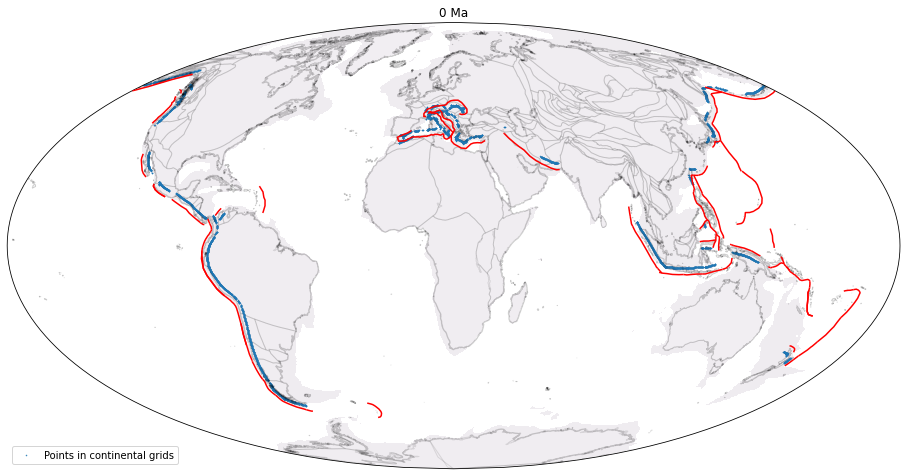

In [9]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 20))
gplot.time = time
gplot.plot_grid_from_netCDF(ax1, continental_grid_directory, cmap="twilight", alpha=0.5, vmin=0, vmax=200)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='1', alpha=0.1)
gplot.plot_trenches(ax1, color='r', zorder=5)

# Plot the trench points in-continent
ax1.scatter(lon_in, lat_in, s=0.25, transform=ccrs.PlateCarree(), label="Points in continental grids")
plt.title("%i Ma" %time)
plt.legend(loc="lower left")